In [1]:
from evaluate import *

/Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
methods = ["DFC", "GNEMS", "DSS", "W-Net"]
# spawn threads
threads = []
for method in methods:
    t = threading.Thread(target=evaluate, args=(method,True))
    threads.append(t)
    t.start()
# wait for threads to finish
for i,t in enumerate(threads):
    t.join()

with open("../results/results.json", "w") as f:
    json.dump(results, f, indent=4)
with open("../results/results.json", "r") as f:
    results = json.load(f)


Evaluating DFC without cache...
Evaluating GNEMS without cache...
Evaluating DSS without cache...
Evaluating W-Net without cache...
Evaluating W-Net on clouds dataset (1/3)...
Evaluating GNEMS on clouds dataset (1/3)...
Evaluating DFC on clouds dataset (1/3)...
Evaluating DSS on clouds dataset (1/3)...
Evaluating DFC on noise dataset (2/3)...
Evaluating DSS on noise dataset (2/3)...
Evaluating GNEMS on noise dataset (2/3)...
Evaluating DSS on texture dataset (3/3)...
Evaluating GNEMS on texture dataset (3/3)...
Evaluating DFC on texture dataset (3/3)...
Evaluating W-Net on noise dataset (2/3)...
DSS evaluation finished
GNEMS evaluation finished
DFC evaluation finished
Evaluating W-Net on texture dataset (3/3)...
W-Net evaluation finished


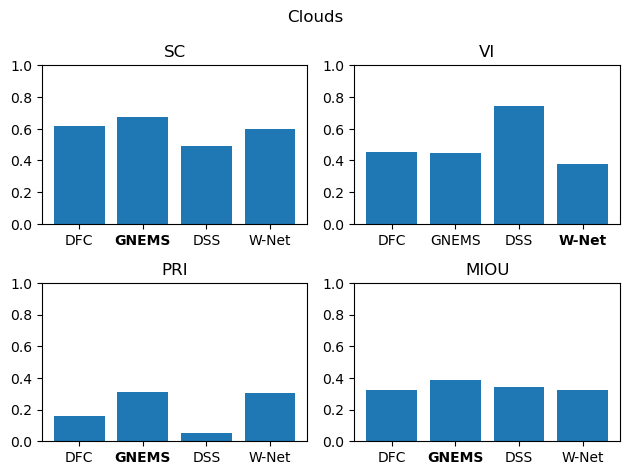

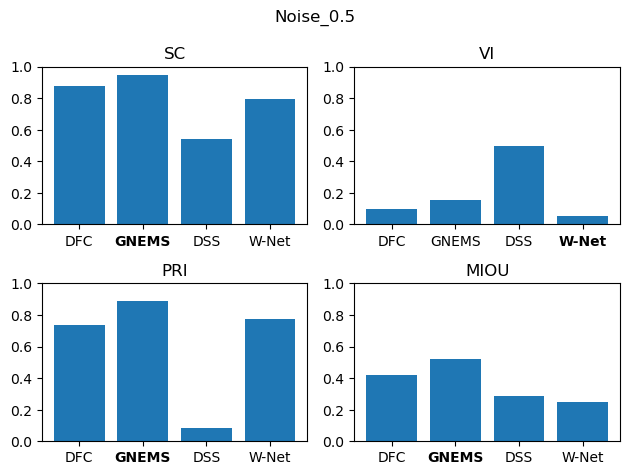

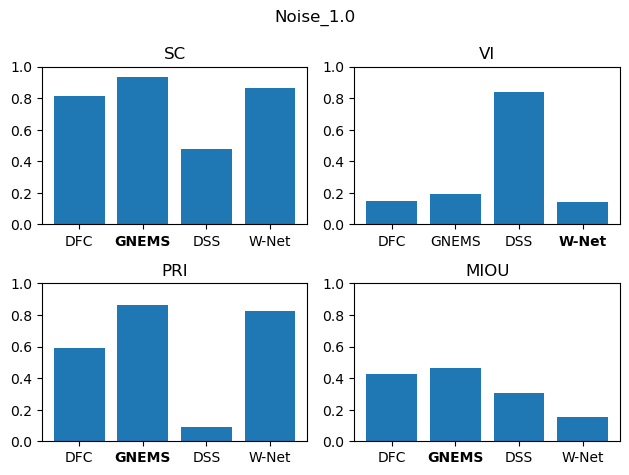

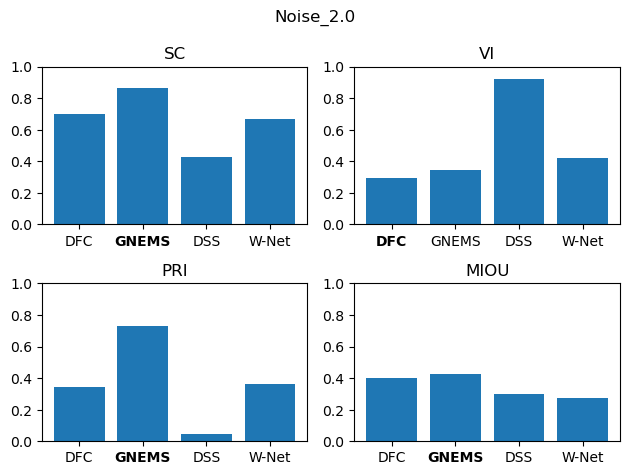

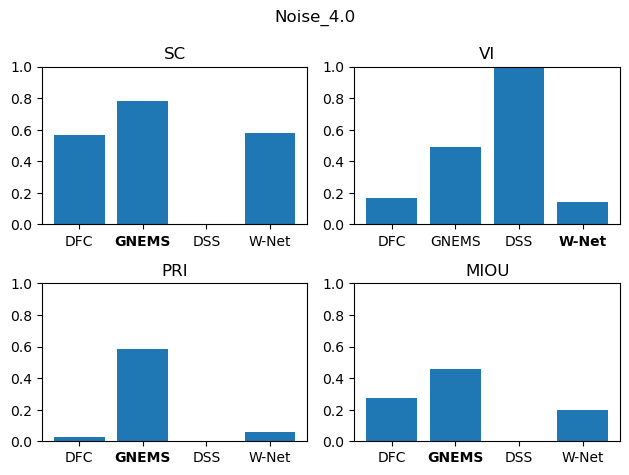

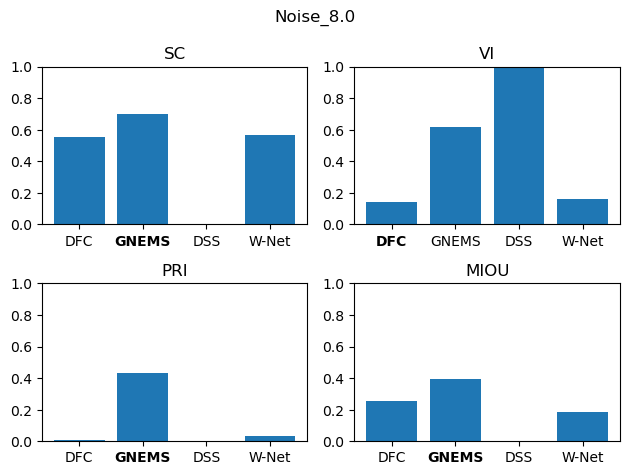

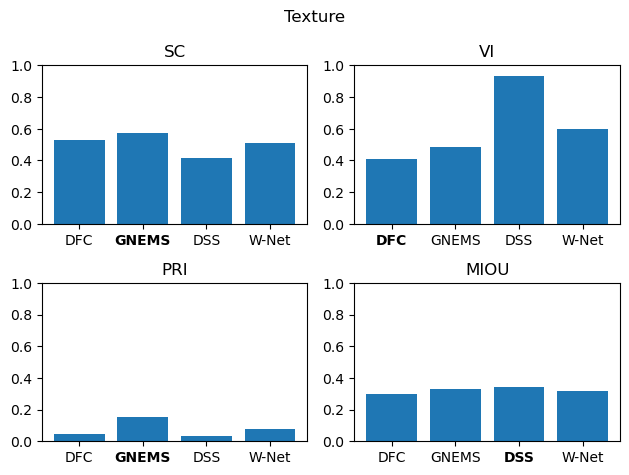

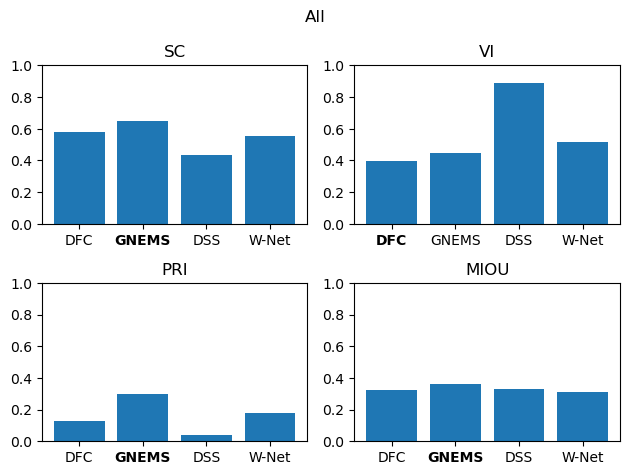

In [3]:
metrics = ["sc", "vi", "pri", "miou"]
tasks = list(results[methods[0]].keys())
for task in tasks:
    fig, axs = plt.subplots(2, 2)
    fig.suptitle(task.capitalize())
    for i,metric in enumerate(metrics):
        values = []
        labels = []
        for method in methods:
            values.append(results[method][task][metric])
            labels.append(method)
        bolding_method = np.argmax if metric.lower() != "vi" else np.argmin
        # labels[bolding_method(values)] = "\\textbf{" + labels[bolding_method(values)] + "}"
        axs[i//2, i%2].bar(labels, values)
        axs[i//2, i%2].set_ylim(0, 1)
        axs[i//2, i%2].set_title(metric.upper())
        axs[i//2, i%2].get_xticklabels()[bolding_method(values)].set_fontweight("bold")
    plt.tight_layout()
    plt.show()
        
        